## Data
- **user_id**: the user_id of customer
- **utm_source**: the location where the ad was placed
- **day**: what day the ad was viewed by the customer
- **ad_click_timestamp**: a timestamp for when the ad was clicked and note that NaN values if the ad was not clicked
- **experimental_group**: which ad, A or B, the customer was shown

### Load Dataset

In [159]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [160]:
# read csv and view first rows
ad_clicks = pd.read_csv('ad_clicks.csv')
ad_clicks.head()

,user_id,utm_source,day,ad_click_timestamp,experimental_group
0,008b7c6c-7272-471e-b90e-930d548bd8d7,google,6 - Saturday,7:18,A
1,009abb94-5e14-4b6c-bb1c-4f4df7aa7557,facebook,7 - Sunday,NaN,B
2,00f5d532-ed58-4570-b6d2-768df5f41aed,twitter,2 - Tuesday,NaN,A
3,011adc64-0f44-4fd9-a0bb-f1506d2ad439,google,2 - Tuesday,NaN,B
4,012137e6-7ae7-4649-af68-205b4702169c,facebook,7 - Sunday,NaN,B


### Data Cleaning

In [161]:
# change to title utm_source
ad_clicks['utm_source'] = ad_clicks['utm_source'].apply(lambda x: x.title()) 

# change type object to datetime in Ad_Click_Timestamp
ad_clicks['ad_click_timestamp'] = pd.to_datetime(ad_clicks['ad_click_timestamp'], format='%H:%M')

# change to title all the columns
title_columns = [column.title() for column in ad_clicks.columns]
ad_clicks.columns = title_columns

### Feature Engineering

In [162]:
# split the day between the name of the day and the number of it
ad_clicks['Day'], ad_clicks['Nro_Day'] = ad_clicks['Day'].apply(lambda x: x.split('-')[1].strip()), \
                                        ad_clicks['Day'].apply(lambda x: x.split('-')[0].strip()).astype(int)

# Add Time Of Day to check when the user clicks during the day
ad_clicks['Time_Of_Day'] = pd.cut(ad_clicks['Ad_Click_Timestamp'].dt.hour, bins=[0, 12, 18, 24], \
                             labels=['Morning', 'Afternoon', 'Night'], right=False)

In [163]:
# Check information about dataset
ad_clicks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1654 entries, 0 to 1653
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   User_Id             1654 non-null   object        
 1   Utm_Source          1654 non-null   object        
 2   Day                 1654 non-null   object        
 3   Ad_Click_Timestamp  565 non-null    datetime64[ns]
 4   Experimental_Group  1654 non-null   object        
 5   Nro_Day             1654 non-null   int32         
 6   Time_Of_Day         565 non-null    category      
dtypes: category(1), datetime64[ns](1), int32(1), object(4)
memory usage: 72.9+ KB


### Analysis Data

In [164]:
# Check that we have approximetely the same amount of participants in each experimental group
ad_clicks.groupby('Experimental_Group', as_index=False).User_Id.count()

,Experimental_Group,User_Id
0,A,827
1,B,827


We have 827 users for each experimental group

In [165]:
# How many views came from each utm_source
views_by_source = ad_clicks.groupby('Utm_Source', as_index=False).agg(
    Count=('User_Id', 'count')
).sort_values('Count', ascending=True, ignore_index=True)

views_by_source

,Utm_Source,Count
0,Twitter,215
1,Email,255
2,Facebook,504
3,Google,680


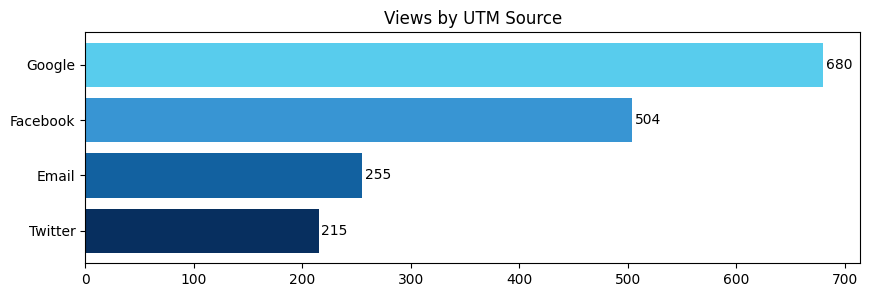

In [166]:
# Let's make a barh to see it in a plot
fig, ax = plt.subplots(figsize=(10,3))

colors = ['#072F5F', '#1261A0', '#3895D3', '#58CCED']

bars = ax.barh(views_by_source['Utm_Source'], width=views_by_source['Count'], color=colors)

ax.set_title('Views by UTM Source')

for bar, source, value in zip(bars, views_by_source['Utm_Source'], views_by_source['Count']):
    ax.text(bar.get_width() + 2.5, bar.get_y() + bar.get_height()/2, f'{value}', ha='left', va='center')

plt.show()

Google has the most views with 680. Twitter, in the other hand, has the lowest number of views.

In [167]:
# if ad_click_timestamp is not null, it indicates that the ad was clicked
ad_clicks['Is_Click']= ad_clicks['Ad_Click_Timestamp'].notnull()
ad_clicks.head()

,User_Id,Utm_Source,Day,Ad_Click_Timestamp,Experimental_Group,Nro_Day,Time_Of_Day,Is_Click
0,008b7c6c-7272-471e-b90e-930d548bd8d7,Google,Saturday,1900-01-01 07:18:00,A,6,Morning,True
1,009abb94-5e14-4b6c-bb1c-4f4df7aa7557,Facebook,Sunday,NaT,B,7,NaN,False
2,00f5d532-ed58-4570-b6d2-768df5f41aed,Twitter,Tuesday,NaT,A,2,NaN,False
3,011adc64-0f44-4fd9-a0bb-f1506d2ad439,Google,Tuesday,NaT,B,2,NaN,False
4,012137e6-7ae7-4649-af68-205b4702169c,Facebook,Sunday,NaT,B,7,NaN,False


In [168]:
clicks_by_source = ad_clicks.groupby(['Utm_Source','Is_Click'], as_index=False).agg(
    Count=('User_Id', 'count')
).sort_values('Count', ascending=True, ignore_index=True)

clicks_by_source

,Utm_Source,Is_Click,Count
0,Twitter,True,66
1,Email,True,80
2,Twitter,False,149
3,Email,False,175
4,Facebook,True,180
5,Google,True,239
6,Facebook,False,324
7,Google,False,441


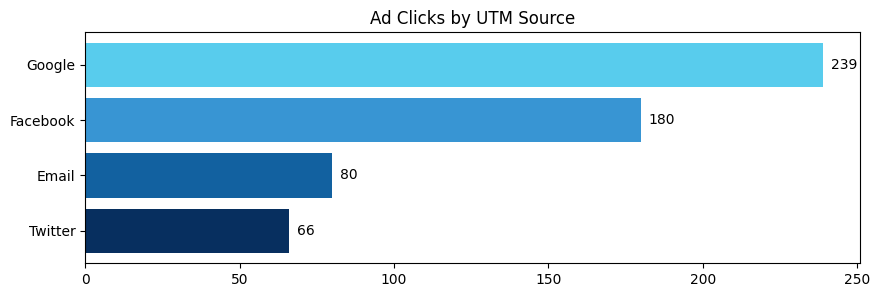

In [169]:
# Let's plot only amount of clicks for each source

# Filter for those records that ad was clicked
clicks_by_source_true = clicks_by_source[clicks_by_source['Is_Click'] == True]

fig, ax = plt.subplots(figsize=(10,3))
bars = ax.barh(clicks_by_source_true['Utm_Source'], width=clicks_by_source_true['Count'], color=colors)

ax.set_title('Ad Clicks by UTM Source')

for bar, source, value in zip(bars, clicks_by_source_true['Utm_Source'], clicks_by_source_true['Count']):
    ax.text(bar.get_width() + 2.5, bar.get_y() + bar.get_height()/2, f'{value}', ha='left', va='center')

plt.show()

Google has the most clicks with 239. Twitter, in the other hand, has the lowest number of clicks.

In [170]:
# Pivot the data so that columns are is_click, the index is utm_source, and values as count
clicks_pivot = clicks_by_source.pivot(columns='Is_Click', index='Utm_Source', values='Count')

# Let's get the conversion rate: those who has clicked v. the total of users that viewed the ad.
clicks_pivot['Conversion_Rate'] = (clicks_pivot[True] / (clicks_pivot[True] + clicks_pivot[False]) * 100).round(2)
clicks_pivot = clicks_pivot.sort_values('Conversion_Rate', ascending = True)
clicks_pivot

Is_Click,False,True,Conversion_Rate
Utm_Source,,,
Twitter,149,66,30.70
Email,175,80,31.37
Google,441,239,35.15
Facebook,324,180,35.71


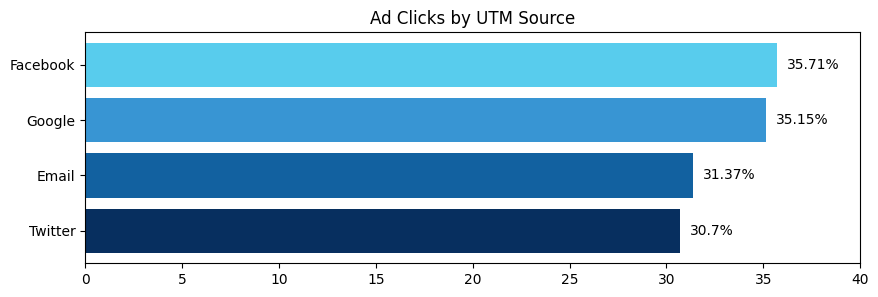

In [171]:
fig, ax = plt.subplots(figsize=(10,3))
bars = ax.barh(clicks_pivot.index, width=clicks_pivot['Conversion_Rate'], color=colors)

ax.set_title('Ad Clicks by UTM Source')
ax.set_xlim(0, 40)

for bar, source, value in zip(bars, clicks_pivot.index, clicks_pivot['Conversion_Rate']):
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, f'{value}%', ha='left', va='center')


plt.show()

Even that Facebook in views and clicks are lower than Google, it has better conversion rate with 35.71% (although is really small difference to Google). Email and Twitter has lower conversion rate than Facebook and Google.

In [172]:
# Analyzing an A/B test. Column experimental_group tells us whether the user was shown Ad A or Ad B.
experimental = ad_clicks.groupby(['Experimental_Group', 'Is_Click'], as_index=False).agg(
    Count=('User_Id', 'count')
).sort_values('Count', ascending=True, ignore_index=True)

experimental

,Experimental_Group,Is_Click,Count
0,B,True,255
1,A,True,310
2,A,False,517
3,B,False,572


In [173]:
# Using the column is_click, check to see if a greater percentage of users clicked on Ad A or Ad B. 

# First lets pivot with is_click as columns, index with experimental_group and user_id as count
experimental_pivot = experimental.pivot(columns='Is_Click', index='Experimental_Group', values='Count')

experimental_pivot['Conversion_Rate'] = (100 * experimental_pivot[True] / \
                                          (experimental_pivot[True] + experimental_pivot[False])).round(2)

experimental_pivot

Is_Click,False,True,Conversion_Rate
Experimental_Group,,,
A,517,310,37.48
B,572,255,30.83


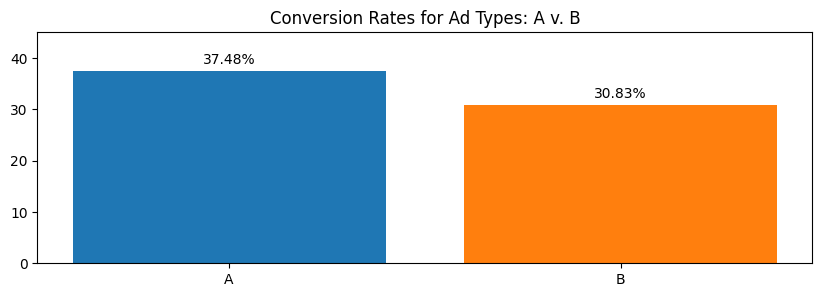

In [243]:
# Get data for plot
range_experimental_pivot = range(len(experimental_pivot))
conversion_rate_values = experimental_pivot['Conversion_Rate'].values

fig, ax = plt.subplots(figsize=(10,3))
bars = plt.bar(range_experimental_pivot,conversion_rate_values,color=['tab:blue','tab:orange'])

ax.set_title('Conversion Rates for Ad Types: A v. B')
ax.set_xticks(range_experimental_pivot,labels = ['A', 'B'])

ax.set_ylim(0, 45)

for bar in bars:
   height = bar.get_height()
   ax.annotate('{:.2f}%'.format(height),
      xy=(bar.get_x() + bar.get_width() / 2, height),
      xytext=(0, 3), 
      textcoords="offset points",
      ha='center', va='bottom')

plt.show()

It was more likely that the user has clicked in the A than B ad

In [226]:
time_of_day = ad_clicks[ad_clicks['Time_Of_Day'].notnull()]
time_grouped = time_of_day.groupby(['Experimental_Group', 'Time_Of_Day'], as_index=False).agg(
    Count = ('User_Id', 'count')
)

time_grouped_A = time_grouped[time_grouped['Experimental_Group'] == 'A']
time_grouped_B = time_grouped[time_grouped['Experimental_Group'] == 'B']

time_grouped_A = time_grouped_A.copy()
time_grouped_A['Percentage'] = (100 * time_grouped_A['Count'] / time_grouped_A['Count'].sum()).round(2) 

time_grouped_B = time_grouped_B.copy()
time_grouped_B['Percentage'] = (100 * time_grouped_B['Count'] / time_grouped_B['Count'].sum()).round(2) 

,Experimental_Group,Time_Of_Day,Count,Percentage
3,B,Morning,133,52.16
4,B,Afternoon,65,25.49
5,B,Night,57,22.35


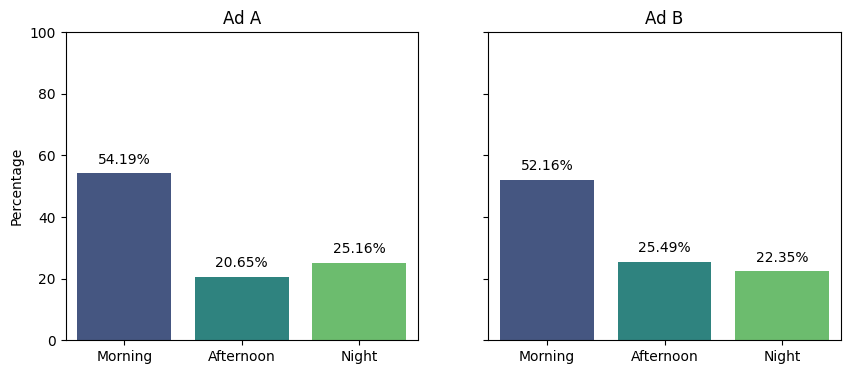

In [252]:
# Plot - Time of Day
fig, ax = plt.subplots(1,2, figsize=(10, 4), sharey=True)

sns.barplot(x='Time_Of_Day' , y='Percentage', data = time_grouped_A, ax=ax[0], palette='viridis')
sns.barplot(x='Time_Of_Day' , y='Percentage', data = time_grouped_B, ax=ax[1], palette='viridis')

for p in ax[0].patches:
    ax[0].annotate(f'{p.get_height()}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    
for p in ax[1].patches:
    ax[1].annotate(f'{p.get_height()}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', xytext=(0, 10), textcoords='offset points')


ax[0].set_xlabel('')
ax[0].set_title('Ad A')

ax[1].set_title('Ad B')
ax[1].set_xlabel('')
ax[1].set_ylabel('')

ax[0].set_ylim(0,100)


plt.show()

In [175]:
# Check the day for each ad if it has a relevant impact

# Subset for each group of ad: A and B.
a_clicks= ad_clicks[ad_clicks.Experimental_Group == 'A']
b_clicks= ad_clicks[ad_clicks.Experimental_Group == 'B']

In [177]:
# Ad A. Lets get the conversion rate for each day
aclicks = a_clicks.groupby(['Is_Click', 'Day', 'Nro_Day'], as_index=False).User_Id.count()

# Pivot
aclicks_pivot = aclicks.pivot(columns='Is_Click',index=['Nro_Day','Day'],values='User_Id')

aclicks_pivot['Conversion_Rate'] = (aclicks_pivot[True] / (aclicks_pivot[True] + aclicks_pivot[False]) * 100).round(2)

aclicks_pivot

,Is_Click,False,True,Conversion_Rate
Nro_Day,Day,,,
1,Monday,70,43,38.05
2,Tuesday,76,43,36.13
3,Wednesday,86,38,30.65
4,Thursday,69,47,40.52
5,Friday,77,51,39.84
6,Saturday,73,45,38.14
7,Sunday,66,43,39.45


In [178]:
# Ad B. Lets get the conversion rate for each day
bclicks = b_clicks.groupby(['Is_Click', 'Day', 'Nro_Day'], as_index=False).User_Id.count()

# Pivot
bclicks_pivot = bclicks.pivot(columns='Is_Click',index=['Nro_Day','Day'],values='User_Id')

bclicks_pivot['Conversion_Rate'] = (bclicks_pivot[True] / (bclicks_pivot[True] + bclicks_pivot[False]) * 100).round(2)

bclicks_pivot

,Is_Click,False,True,Conversion_Rate
Nro_Day,Day,,,
1,Monday,81,32,28.32
2,Tuesday,74,45,37.82
3,Wednesday,89,35,28.23
4,Thursday,87,29,25.00
5,Friday,90,38,29.69
6,Saturday,76,42,35.59
7,Sunday,75,34,31.19


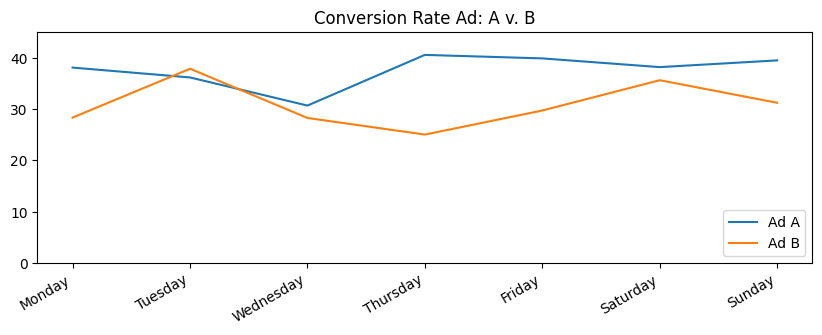

In [179]:
a_is_click = range(len(aclicks_pivot))
a_pclick = aclicks_pivot['Conversion_Rate'].values

b_is_click = range(len(bclicks_pivot))
b_pclick = bclicks_pivot['Conversion_Rate'].values

unique_days_order = ad_clicks[['Day', 'Nro_Day']].drop_duplicates().sort_values('Nro_Day')

fig, ax = plt.subplots(figsize=(10,3))

ax.plot(a_is_click,a_pclick,label='Ad A')
ax.plot(b_is_click,b_pclick,label='Ad B')

ax.set_title('Conversion Rate Ad: A v. B')

ax.set_xticks(a_is_click)
ax.set_xticklabels(unique_days_order['Day'], rotation=30, ha='right')

ax.set_ylim(0, 45)

plt.legend(loc="lower right")
plt.show()

The performance of Ad A outpaced that of Ad B, mostly each day of the week. Ad B only performed better than Ad A on Tuesday.

# Conclusion
- We can say that the sample is fair for both Ad with 827 records
- We get the amount of views and clicks of users for each source and their conversion rate
- We observe that Google has more views and clicks but regarding of conversion rate, Facebook has the highest percentage against Google and the other social media
- Both Google and Facebook have the mayority of the sample. That's why they have the highest percentage of active users who have clicked in the ads.
- We get that the best time for the user to click is in the morning in both ads. It almost duplicates the percentage of clicks
- Also we analyzed the day of the week who affects the click to answer which ad performs better.
- We learned that Ad A has better performance than Ad B, regardless that just in Tuesday is better.
- Therefore, We'd recommend the ad A and priorize all the resources for advertsing in Google or Facebook to maximize the user traffic into ShoeFly.com
